In [327]:
import warnings
warnings.filterwarnings('ignore') # Wow nice.

In [328]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras import backend as K

from alexnet import AlexNet
from vgg7 import SmallVGGNet

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg') # Non-interactive

import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import train_test_split

import numpy as np
from imutils import paths, resize
import cv2
import os

## Network architecture

In [329]:
net = SmallVGGNet()
# net = AlexNet()
model = net.build(32, 32, num_classes=3) # Using 3 classes Dog, Cat and Panda

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_164 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_137 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_165 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_138 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 16, 16, 32)        0         
__________

## Loading, processing and splitting the dataset

In [330]:
print('# Loading Animals dataset...')
# trainX = training set datapoints, trainY = training set labels
# Same of testing set
image_paths = list(paths.list_images('/floyd/input/animals'))
print('Samples:', image_paths[0: 5])
print('# Animals dataset loaded!')

# Loading Animals dataset...
Samples: ['/floyd/input/animals/panda/panda_00524.jpg', '/floyd/input/animals/panda/panda_00594.jpg', '/floyd/input/animals/panda/panda_00866.jpg', '/floyd/input/animals/panda/panda_00889.jpg', '/floyd/input/animals/panda/panda_00680.jpg']
# Animals dataset loaded!


In [331]:
# Resize images and get labels
images = []
labels = []

def resize_image(image, width=32, height=32, inter=cv2.INTER_AREA, keep_ratio=False):
    def get_dim(image):
        return image.shape[:2]
    
    if not keep_ratio:
        return cv2.resize(image, (width, height), interpolation=inter)
    else:
        try:
            (h, w) = get_dim(image)
            dH = 0
            dW = 0

            if w < h:
                image = resize(image, width=width, inter=inter)
                dH = int((image.shape[0] - height) / 2.0)
            else:
                image = resize(image, height=height, inter=inter)
                dH = int((image.shape[1] - width) / 2.0)

            (h, w) = get_dim(image)
            image = image[dH:h - dH, dW:w - dW]

            return cv2.resize(image, (width, height), interpolation=inter)
        except Exception as e:
            pass

# Mean colors
(R, G, B) = ([], [], [])
        
for path in image_paths:
    # Looad the image
    image = cv2.imread(path)
    # Resize the image
    image = resize_image(image, keep_ratio=False)
    # Sometimes it fails to resize the image, 
    # so don't add it (we don't care as it is a test)
    if image is not None:
        # Extract a random crop from the image
        image = extract_patches_2d(image, (32, 32), max_patches=1)[0]
        # Transform image to array
        image = img_to_array(image, data_format=None)
        # Append image and its associate label
        images.append(image)
        labels.append(path.split(os.path.sep)[-2])

# Convert the dataset to numpy array
images = np.array(images)
print(len(images))

3000


In [332]:
# Scale the pixel intensity values to the range [0, 1]
def normalize(images):
    return images.astype('float') / 255.0

images = normalize(images)

In [333]:
# Split the data into training and testing sets 75/25
(trainX, testX, trainY, testY) = train_test_split(images, labels, test_size=0.25, random_state=42)

In [334]:
# Convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)
print('After converting:', trainY)

After converting: [[0 1 0]
 [0 0 1]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [0 0 1]]


In [335]:
# Set labels names for easier reading
label_names = ['Dog', 'Cat', 'Panda']

In [336]:
# Handle data augmentation
daug = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

## Train the network

In [337]:
# Define the number of epochs (times dataset has been seen)
num_epochs = 100
# Set the optimizer (here using Stochastic Gradient Descent with a learning rate of X, epochs-based decay and a momentum)
# Decay slowly reduces the learning rate to reduce overfitting and get higher classification accc
sgd_opt = SGD(lr=0.01, decay=0.01 / num_epochs, momentum=0.9, nesterov=True)
# adam_opt = Adam(lr=1e-3)
# Compile the model
print('# Compiling the model...')
model.compile(loss='categorical_crossentropy', optimizer=sgd_opt, metrics=['accuracy'])
# Train the network!
print('# Training the network...')
M = model.fit_generator(daug.flow(trainX, trainY, batch_size=32), validation_data=(testX, testY),
                        epochs=num_epochs, steps_per_epoch=len(trainX) // 32, verbose=1)

# Compiling the model...
# Training the network...
Epoch 1/100
70/70 [==============================] - 8s 116ms/step - loss: 1.4866 - acc: 0.5089 - val_loss: 3.6138 - val_acc: 0.3360
Epoch 2/100
70/70 [==============================] - 2s 23ms/step - loss: 1.3002 - acc: 0.5662 - val_loss: 2.7497 - val_acc: 0.3533
Epoch 3/100
70/70 [==============================] - 2s 23ms/step - loss: 1.2242 - acc: 0.5720 - val_loss: 1.6531 - val_acc: 0.4453
Epoch 4/100
70/70 [==============================] - 2s 23ms/step - loss: 1.2124 - acc: 0.5705 - val_loss: 1.5447 - val_acc: 0.4547
Epoch 5/100
70/70 [==============================] - 2s 22ms/step - loss: 1.1934 - acc: 0.5951 - val_loss: 1.0227 - val_acc: 0.6080
Epoch 6/100
70/70 [==============================] - 2s 22ms/step - loss: 1.0973 - acc: 0.6022 - val_loss: 0.8817 - val_acc: 0.6347
Epoch 7/100
70/70 [==============================] - 2s 23ms/step - loss: 1.0371 - acc: 0.6058 - val_loss: 0.9582 - val_acc: 0.6560
Epoch 8/100
70/70 [=====

## Evalute the network

# Trained the network! Evaluating...
              precision    recall  f1-score   support

         Dog       0.80      0.57      0.67       249
         Cat       0.63      0.82      0.71       239
       Panda       0.94      0.94      0.94       262

   micro avg       0.78      0.78      0.78       750
   macro avg       0.79      0.78      0.77       750
weighted avg       0.79      0.78      0.77       750



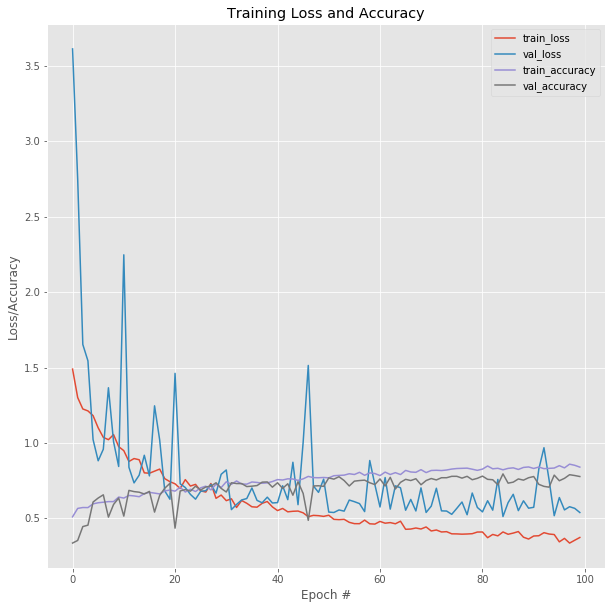

In [338]:
# Evalutate the network
print('# Trained the network! Evaluating...')
preds = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
preds.argmax(axis=1), target_names=label_names))

%matplotlib inline
# Plot history to check for overfitting
plt.style.use('ggplot')
plt.figure(figsize=(10, 10))
plt.plot(np.arange(0, num_epochs), M.history['loss'], label='train_loss')
plt.plot(np.arange(0, num_epochs), M.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, num_epochs), M.history['acc'], label='train_accuracy')
plt.plot(np.arange(0, num_epochs), M.history['val_acc'], label='val_accuracy')

plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend()

plt.show()